In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os

In [8]:
import zipfile

zip_files = ['test1', 'train']
# Will unzip the files so that you can see them..
for zip_file in zip_files:
    with zipfile.ZipFile("/home/ubuntu/Dogs Cats/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [13]:
filenames = os.listdir(r"/home/ubuntu/Dogs Cats/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,dog.9030.jpg,1
1,dog.8017.jpg,1
2,cat.4250.jpg,0
3,dog.5106.jpg,1
4,cat.6760.jpg,0


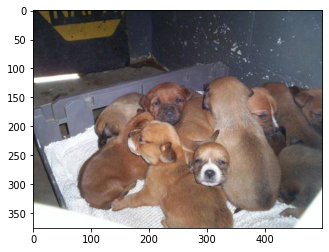

In [15]:
sample = random.choice(filenames)
image = load_img(r"/home/ubuntu/Dogs Cats/train/"+sample)
plt.imshow(image)

In [16]:
iar=np.array(image)
print(iar)

[[[ 10  20  11]
  [ 21  31  22]
  [ 29  39  31]
  ...
  [ 65  88 106]
  [ 65  88 106]
  [ 65  88 106]]

 [[ 16  26  17]
  [ 19  29  20]
  [ 21  31  23]
  ...
  [ 67  90 108]
  [ 67  90 108]
  [ 67  90 108]]

 [[ 20  30  21]
  [ 16  26  17]
  [ 12  22  14]
  ...
  [ 68  91 109]
  [ 68  91 109]
  [ 68  91 109]]

 ...

 [[253 255 254]
  [253 255 254]
  [253 255 254]
  ...
  [253 255 254]
  [253 255 254]
  [253 255 254]]

 [[253 255 254]
  [253 255 254]
  [253 255 254]
  ...
  [253 255 254]
  [253 255 254]
  [253 255 254]]

 [[253 255 254]
  [253 255 254]
  [253 255 254]
  ...
  [253 255 254]
  [253 255 254]
  [253 255 254]]]


In [17]:
width=128
height=128
size=(width,height)
channels=3

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,Dropout,Flatten,Dense,Activation,BatchNormalization

In [19]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(width,height,channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [21]:
earlystop = EarlyStopping(patience=5)

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [23]:
callbacks = [earlystop, learning_rate_reduction]

In [24]:
train_df,validate_df=train_test_split(df,test_size=0.2,random_state=4)
train_df=train_df.reset_index(drop=True)
validate_df=validate_df.reset_index(drop=True)

In [25]:
train_df.head()

,filename,category
0,dog.11487.jpg,1
1,dog.3050.jpg,1
2,cat.6156.jpg,0
3,dog.1883.jpg,1
4,cat.8067.jpg,0


In [26]:
train_df['category'].value_counts()

1    10039
0     9961
Name: category, dtype: int64

In [27]:
import tensorflow as tf
train_df['category']=train_df['category'].astype('str')
validate_df['category']=validate_df['category'].astype('str')

In [29]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    r"/home/ubuntu/Dogs Cats/train", 
    x_col='filename',
    y_col='category',
    target_size=size,
    class_mode='categorical',
    batch_size=15
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    r"/home/ubuntu/Dogs Cats/train", 
    x_col='filename',
    y_col='category',
    target_size=size,
    class_mode='categorical',
    batch_size=20
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [30]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
callbacks=[earlystop, learning_rate_reduction]

In [31]:
epochs=15
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//20,
    steps_per_epoch=total_train//20,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
1000/1000 [==============================] - 459s 459ms/step - loss: 0.7893 - accuracy: 0.5997 - val_loss: 0.6544 - val_accuracy: 0.6046
Epoch 2/15
1000/1000 [==============================] - 452s 452ms/step - loss: 0.6289 - accuracy: 0.6594 - val_loss: 0.7330 - val_accuracy: 0.6458
Epoch 3/15
1000/1000 [==============================] - 453s 453ms/step - loss: 0.6060 - accuracy: 0.6798 - val_loss: 0.5800 - val_accuracy: 0.6980
Epoch 4/15
1000/1000 [==============================] - 452s 452ms/step - loss: 0.5840 - accuracy: 0.6950 - val_loss: 0.5259 - val_accuracy: 0.7372
Epoch 5/15
1000/1000 [==============================] - 450s 450ms/step - loss: 0.5460 - accuracy: 0.7265 - val_loss: 0.7334 - val_accuracy: 0.6594
Epoch 6/15
1000/1000 [==============================] - 452s 452ms/step - loss: 0.5283 - accuracy: 0.7405 - val_loss: 0.6281 - val_accuracy: 0.7026
Epoch 7/15
1000/1000 [==============

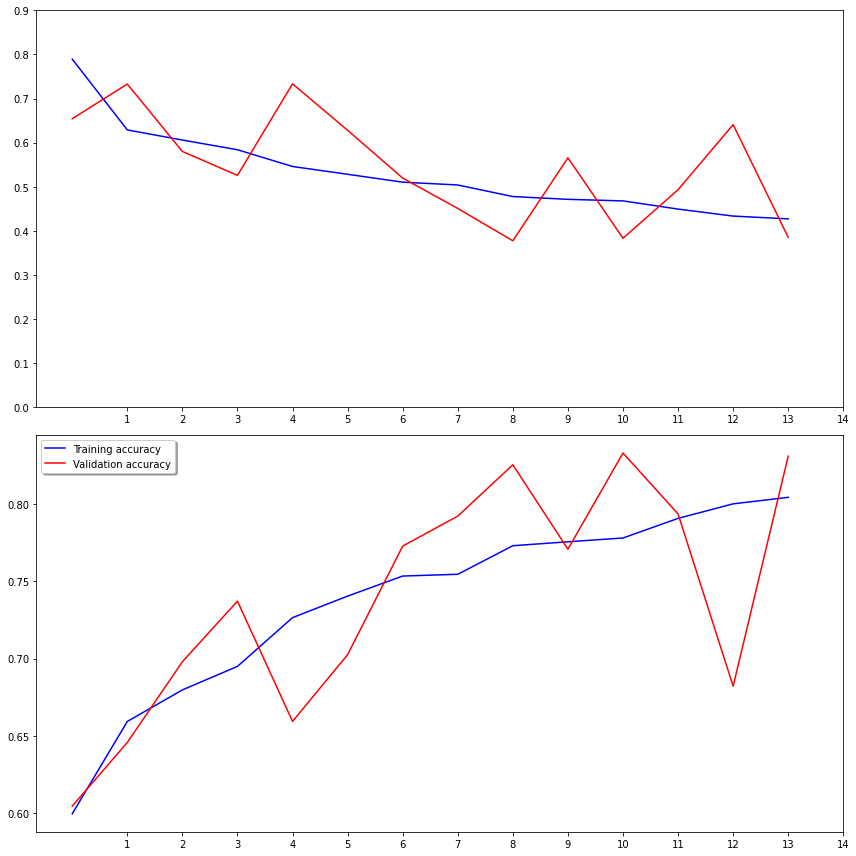

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()